In [ ]:
"""
8/12/2021
hybrid AP-CO test (only 1 model)
"""

'\n8/12/2021\nhybrid AP-CO test (only 1 model)\n'

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import numpy as np
import math
import random
import matplotlib.pyplot as plt
%matplotlib inline
!pip install scipy==1.7.1
import scipy
print(scipy.__version__)

     |████████████████████████████████| 28.5 MB 1.4 MB/s 
  Attempting uninstall: scipy
    Found existing installation: scipy 1.4.1
    Uninstalling scipy-1.4.1:
      Successfully uninstalled scipy-1.4.1
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
albumentations 0.1.12 requires imgaug<0.2.7,>=0.2.5, but you have imgaug 0.2.9 which is incompatible.
1.7.1


In [ ]:
## CONFIG ##
############

# sampling interval (s)
DELTA_T = 30

# number of linear model
N = 20

# time simulation (s)
T_SIMULATION = 400*DELTA_T

# Fitted Parameter
RESPONSE_PARAM = {
    'DB-CO': {'Ku': 15.8,  'T': 164.3, 'L': 30, 'P1': 105.3, 'P2': 0.028},
    'DB-AP': {'Ku': 4.4,   'T': 65.2,  'L': 30, 'P1': 22.8,  'P2': 0.145},
    'SN-CO': {'Ku': 3.0,   'T': 40.6,  'L': 60, 'P1': 37.7,  'P2': 0.051},
    'SN-AP': {'Ku': -12.5, 'T': 209.4, 'L': 60, 'P1': -26.2, 'P2': -0.085}
}

In [ ]:
# Create Range T
RANGE_T = list(range(DELTA_T, T_SIMULATION+1, DELTA_T))
RANGE_T.insert(0, 0) # [0, 30, 60, ...]

# MODELING
def math_model(u, drug_response):

    Ku = RESPONSE_PARAM[drug_response]['Ku']
    T = RESPONSE_PARAM[drug_response]['T']
    L = RESPONSE_PARAM[drug_response]['L']
    P1 = RESPONSE_PARAM[drug_response]['P1']
    P2 = RESPONSE_PARAM[drug_response]['P2']


    unit_impulse = [ (Ku/T)*np.exp(-(t-L)/T)*DELTA_T if t>=L else 0 for t in RANGE_T ]

    out_linear = []
    out_nonlinear = []

    for t_index in range(0, len(u)):
        if t_index < N:
            out_linear.append(0)
            out_nonlinear.append(0)
        else:
            temp = 0
            for to in range(0, N+1):
                temp += unit_impulse[to] * u[t_index-to]

            out_linear.append(temp)
            out_nonlinear.append(P1 * math.tanh((P2*temp)/2))


    return out_linear, out_nonlinear


###########
INPUT_DB = [0]
for t in range(0, len(RANGE_T)):
    INPUT_DB.append(random.uniform(-4, 6))

INPUT_SN = [0]
for t in range(0, len(RANGE_T)):
    INPUT_SN.append(random.uniform(-4, 6))
###########


CO1_linear, CO1_nonlinear = math_model(u=INPUT_DB, drug_response='DB-CO')
CO2_linear, CO2_nonlinear = math_model(u=INPUT_SN, drug_response='SN-CO')

AP1_linear, AP1_nonlinear = math_model(u=INPUT_SN, drug_response='SN-AP')
AP2_linear, AP2_nonlinear = math_model(u=INPUT_DB, drug_response='DB-AP')

k1, k2, l1, l2 = 1, 1, 1, 1
CO = [None]*len(RANGE_T)
AP = [None]*len(RANGE_T)
for t in range(0, len(RANGE_T)):
    CO[t] = k1*CO1_nonlinear[t] + k2*CO2_nonlinear[t]
    AP[t] = l1*AP1_nonlinear[t] + l2*AP2_nonlinear[t]

LENGTH_DATA = len(RANGE_T)


Text(0.5, 1.0, 'Input SN')

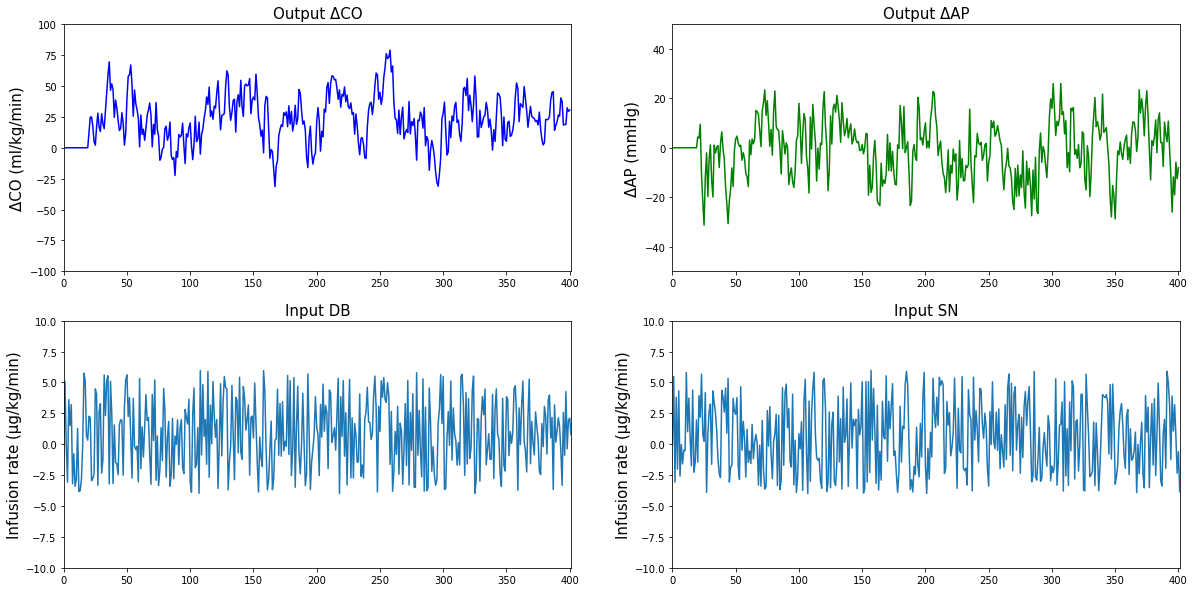

In [ ]:
plt.figure(figsize=(20,10))

plt.subplot(221)
plt.plot(CO, 'b')
plt.xlim((0, LENGTH_DATA))
plt.ylim((-100, 100))
plt.ylabel('ΔCO (ml/kg/min)', fontsize=15)
plt.title('Output ΔCO', fontsize=15)

plt.subplot(222)
plt.plot(AP, 'g')
plt.xlim((0, LENGTH_DATA))
plt.ylim((-50, 50))
plt.ylabel('ΔAP (mmHg)', fontsize=15)
plt.title('Output ΔAP', fontsize=15)

plt.subplot(223)
plt.plot(INPUT_DB)
plt.xlim((0, LENGTH_DATA))
plt.ylim((-10, 10))
plt.ylabel('Infusion rate (μg/kg/min)', fontsize=15)
plt.title('Input DB', fontsize=15)

plt.subplot(224)
plt.plot(INPUT_SN)
plt.xlim((0, LENGTH_DATA))
plt.ylim((-10, 10))
plt.ylabel('Infusion rate (μg/kg/min)', fontsize=15)
plt.title('Input SN', fontsize=15)

In [ ]:
"""
Prepare Dataset
"""
from sklearn.preprocessing import StandardScaler

def prepare_data_model(input_DB, input_SN, output_CO, output_AP, ratio_train):

    ## GENERATE MATRIX DATASET
    x_list = []
    y_list = []
    for i in range(25, len(output_CO)):
        row1 = input_DB[i-2 : i]
        row2 = input_SN[i-2 : i]
        row3 = [output_CO[i-1], output_AP[i-1]]

        arr1d = np.array([row1, row2, row3]).reshape(-1,)
        x_list.append(arr1d)
        y_list.append([output_CO[i], output_AP[i]])

    x = np.array(x_list)
    y = np.array(y_list)

    print('original x:', x.shape)
    print('original y:', y.shape)

    ## SPLIT DATASET
    cut_test = int(ratio_train * x.shape[0]) # 80% of x --> train+val
    x_model_train = x[: cut_test]
    y_model_train = y[: cut_test]
    x_model_test = x[cut_test:]
    y_model_test = y[cut_test:]


    ## Normalize
    scaler_x = StandardScaler().fit(x_model_train)
    scaler_y = StandardScaler().fit(y_model_train)

    x_model_train_norm = scaler_x.transform(x_model_train)
    y_model_train_norm = scaler_y.transform(y_model_train)

    x_model_test_norm = scaler_x.transform(x_model_test)
    y_model_test_norm = scaler_y.transform(y_model_test)


    ## Split train,val
    cut_train = int(0.8 * x_model_train.shape[0]) # 80% of (80% of x)
    x_train = x_model_train_norm[: cut_train]
    y_train = y_model_train_norm[: cut_train]
    x_val = x_model_train_norm[cut_train:]
    y_val = y_model_train_norm[cut_train:]


    ## SCALE INPUT
    x_train = x_train.reshape((-1, 3, 2, 1))
    y_train = y_train.reshape((-1, 2))

    x_val = x_val.reshape((-1, 3, 2, 1))
    y_val = y_val.reshape((-1, 2))

    x_test = x_model_test_norm.reshape((-1, 3, 2, 1))
    y_test = y_model_test_norm.reshape((-1, 2))

    print('x_train: ', x_train.shape)
    print('y_train: ', y_train.shape)
    print('x_val: ', x_val.shape)
    print('y_val: ', y_val.shape)
    print('x_test: ', x_test.shape)
    print('y_test: ', y_test.shape)


    # ## Try
    # print(x_model_train[0])
    # print(x_model_train_norm[0])
    # print(x_train[0])

    ##
    return x_train, x_val, x_test, y_train, y_val, y_test, scaler_x, scaler_y

#############


In [ ]:
# CNN
import tensorflow.keras as keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten, Conv2D, MaxPooling2D
from tensorflow.keras.wrappers.scikit_learn import KerasClassifier
from numpy.random import seed
seed(7)

###############################
def create_model(INPUT_SHAPE):
    """
    Create CNN models
    """
    model = Sequential()
    model.add(Conv2D(filters=12, kernel_size=3, padding="same", activation="relu", input_shape=INPUT_SHAPE))
    model.add(MaxPooling2D(pool_size=(2,2), padding="same"))

    model.add(Conv2D(filters=12, kernel_size=3, padding="same", activation="relu"))
    model.add(MaxPooling2D(pool_size=(2,2), padding="same"))

    model.add(Conv2D(filters=12, kernel_size=3, padding="same", activation="relu"))
    model.add(MaxPooling2D(pool_size=(2,2), padding="same"))

    model.add(Flatten())
    model.add(Dense(16, activation="relu"))
    model.add(Dense(8, activation="relu"))
    model.add(Dense(2))

    opt = keras.optimizers.Adam(learning_rate=0.001)
    model.compile(loss='mae', optimizer=opt)

    return model


In [ ]:
# ## Create Data
# RATIO_TRAIN = 0.8

# x_train, x_val, x_test, y_train, y_val, y_test, scaler_x, scaler_y = prepare_data_model(INPUT_DB, INPUT_SN, CO, AP, RATIO_TRAIN)

# # Train Model
# BATCH_SIZE=16
# EPOCHS=200
# model = create_model(INPUT_SHAPE = (3,2,1))
# history = model.fit(x_train, y_train,
#                 epochs=EPOCHS,
#                 batch_size=BATCH_SIZE,
#                 validation_data=(x_val, y_val),
#                 verbose=1)

# # Plot
# plt.figure(figsize=(15, 8))
# plt.plot(history.history['loss'])
# plt.plot(history.history['val_loss'])
# plt.title('model loss')
# plt.legend(['train', 'val'], loc='upper right')
# plt.show()

# model.save('base_model.h5')


In [ ]:
# from sklearn.metrics import mean_absolute_error
# from scipy.stats import pearsonr

# # Predict
# len_pred = x_test.shape[0]
# pred = model.predict(x_test)

# # Convert to pre-scale
# pred_convert = scaler_y.inverse_transform(pred)

# # Metrics
# mae_CO = mean_absolute_error(CO[-len_pred:], pred_convert[:,0])
# mae_AP = mean_absolute_error(AP[-len_pred:], pred_convert[:,1])
# rCO = pearsonr(CO[-len_pred:], pred_convert[:,0])[0]
# rAP = pearsonr(AP[-len_pred:], pred_convert[:,1])[0]


# # Plot
# plt.figure(figsize=(20, 15))
# plt.subplot(221)
# plt.plot(CO[-len_pred:], 'g--o', label='CO true')
# plt.plot(pred_convert[:,0], 'g-*', label='CO pred')
# plt.title('MAE = %.3f' %mae_CO)
# plt.ylim((-40, 80))
# plt.legend()

# plt.subplot(222)
# plt.plot(CO[-len_pred:], pred_convert[:,0], 'g*')
# plt.plot([-20, 80], [-20, 80], 'k--')
# plt.title('r = %.3f' %rCO)
# plt.xlim((-40, 80))
# plt.ylim((-40, 80))

# plt.subplot(223)
# plt.plot(AP[-len_pred:], 'b--o', label='AP true')
# plt.plot(pred_convert[:,1], 'b-*', label='AP pred')
# plt.title('MAE = %.3f' %mae_AP)
# plt.ylim((-40, 40))
# plt.legend()

# plt.subplot(224)
# plt.plot(AP[-len_pred:], pred_convert[:,1], 'b*')
# plt.plot([-40, 40], [-40, 40], 'k--')
# plt.title('r = %.3f' %rAP)
# plt.xlim((-40, 40))
# plt.ylim((-40, 40))



In [ ]:
from tensorflow import keras
import pickle

def save_to_pickle(path, item):
    with open(path, 'ab') as file:
        pickle.dump(item, file, pickle.HIGHEST_PROTOCOL)


def read_from_pickle(path):
    with open(path, 'rb') as file:
        result = pickle.load(file)

    return result


# inputs = (INPUT_DB, INPUT_SN)
# save_to_pickle('/content/drive/MyDrive/drug_infusion/scaler.pkl', (scaler_x, scaler_y))
# save_to_pickle('/content/drive/MyDrive/drug_infusion/inputs.pkl', inputs)
# save_to_pickle('/content/drive/MyDrive/drug_infusion/model_history.pkl', history)

# model.save('/content/drive/MyDrive/drug_infusion/model_base.h5')

model_base = keras.models.load_model('/content/drive/MyDrive/drug_infusion/drug_interact/model_base.h5')
(scaler_x, scaler_y) = read_from_pickle('/content/drive/MyDrive/drug_infusion/drug_interact/scaler.pkl')
(INPUT_DB, INPUT_SN) = read_from_pickle('/content/drive/MyDrive/drug_infusion/drug_interact/inputs.pkl')


In [ ]:
## CONTROLLER

# nelder-mead optimization of a convex function
from scipy.optimize import minimize
from numpy.random import rand


###############################################
def math_response_current(input_DB, input_SN, sensitivity, offset_CO, offset_AP):
    """
    Mathematical Non-linear Model Response (current time step)
    Need at least 20 previous (history) data
    """

    (a1, a2, b1, b2) = sensitivity

    CO1_linear, CO1_nonlinear = math_model(u=input_DB, drug_response='DB-CO')
    CO2_linear, CO2_nonlinear = math_model(u=input_SN, drug_response='SN-CO')

    AP1_linear, AP1_nonlinear = math_model(u=input_SN, drug_response='SN-AP')
    AP2_linear, AP2_nonlinear = math_model(u=input_DB, drug_response='DB-AP')

    # a1, a2, b1, b2 = 1, 1, 1, 1
    CO = a1*np.array(CO1_nonlinear) + a2*np.array(CO2_nonlinear)
    AP = b1*np.array(AP1_nonlinear) + b2*np.array(AP2_nonlinear)

    return CO[-1]+offset_CO, AP[-1]+offset_AP


###############################################
# def model_update(model, input_list, label):
#     """
#     Update weights of models
#     """
#     arr = np.array(input_list).reshape(1, 6)
#     arr_norm = scaler_x.transform(arr)
#     arr_norm = arr_norm.reshape(-1, 3, 2, 1)

#     label = np.array(label).reshape(-1, 1)
#     label_norm = scaler_y.transform(label)

#     model.fit(arr_norm, label_norm,
#                 epochs=20,
#                 verbose=0)

#     return model



###############################################
def model_predict_future(model, input_list):
    """
    Neural Network Model to predict (future time-step)
    Input: list of 6 elements
    """
    arr = np.array(input_list).reshape(1, 6)
    arr_norm = scaler_x.transform(arr)
    arr_test = arr_norm.reshape(-1, 3, 2, 1)
    pred = model.predict(arr_test)
    pred_convert = scaler_y.inverse_transform(pred)

    return pred_convert[0,0], pred_convert[0,1]



###############################################
def calculate_loss(x, input_DB, input_SN, r_CO_desire, r_AP_desire, model_current, sensitivity, offset_CO, offset_AP):
    """
    Calculate Loss Function
    """
    DB_current = x[0]
    SN_current = x[1]

    DB_minus1 = input_DB[-1]
    SN_minus1 = input_SN[-1]

    output_CO_current, output_AP_current = math_response_current(input_DB + [DB_current],
                                                                input_SN + [SN_current],
                                                                 sensitivity,
                                                                 offset_CO, offset_AP)

    ## predict output_cnn[step+1]
    list_input0 = [DB_minus1, DB_current,
                    SN_minus1, SN_current,
                    output_CO_current, output_AP_current]

    predict_CO_plus1, predict_AP_plus1 = model_predict_future(model_current, list_input0)


    ## predict output_cnn[step+2]
    DB_plus1 = DB_current
    SN_plus1 = SN_current
    output_CO_plus1, output_AP_plus1 = math_response_current(input_DB + [DB_current]*2,
                                                              input_SN + [SN_current]*2,
                                                             sensitivity,
                                                             offset_CO, offset_AP)

    list_input1 = [DB_current, DB_plus1,
                    SN_current, SN_plus1,
                    output_CO_plus1, output_AP_plus1]

    predict_CO_plus2, predict_AP_plus2 = model_predict_future(model_current, list_input1)


    ## predict output_cnn[step+3]
    DB_plus2 = DB_current
    SN_plus2 = SN_current
    output_CO_plus2, output_AP_plus2 = math_response_current(input_DB + [DB_current]*3,
                                                              input_SN + [SN_current]*3,
                                                             sensitivity,
                                                             offset_CO, offset_AP)

    list_input2 = [DB_plus1, DB_plus2,
                    SN_plus1, SN_plus2,
                    output_CO_plus2, output_AP_plus2]

    predict_CO_plus3, predict_AP_plus3 = model_predict_future(model_current, list_input2)


    ## predict output_cnn[step+4]
    DB_plus3 = DB_current
    SN_plus3 = SN_current
    output_CO_plus3, output_AP_plus3 = math_response_current(input_DB + [DB_current]*4,
                                                              input_SN + [SN_current]*4,
                                                             sensitivity,
                                                             offset_CO, offset_AP)

    list_input3 = [DB_plus2, DB_plus3,
                    SN_plus2, SN_plus3,
                    output_CO_plus3, output_AP_plus3]

    predict_CO_plus4, predict_AP_plus4 = model_predict_future(model_current, list_input3)


    ## loss function
    loss = (predict_CO_plus1 - r_CO_desire)**2 + (predict_AP_plus1 - r_AP_desire)**2 + \
            (predict_CO_plus2 - r_CO_desire)**2 + (predict_AP_plus2 - r_AP_desire)**2 + \
            (predict_CO_plus3 - r_CO_desire)**2 + (predict_AP_plus3 - r_AP_desire)**2 + \
            (predict_CO_plus4 - r_CO_desire)**2 + (predict_AP_plus4 - r_AP_desire)**2 + \
            0.01*(DB_current-DB_minus1)**2 + 0.01*(SN_current-SN_minus1)**2



    # print('(DB,SN)=(%.2f, %.2f) | (math_CO, math_AP)=(%.2f, %.2f) | (r_CO, cnn_CO)=(%.2f, %.2f) | (r_AP, cnn_AP)=(%.2f, %.2f) | loss=%.2f'
    #       %(DB_current, SN_current, output_CO_current, output_AP_current, r_CO_desire, predict_CO_plus1, r_AP_desire, predict_AP_plus1, loss))

    return loss



###############################################
def optimize_nelder(input_DB, input_SN, r_CO, r_AP, model_current, sensitivity, offset_CO, offset_AP):

    objective = lambda x: calculate_loss(x, input_DB, input_SN, r_CO, r_AP, model_current, sensitivity, offset_CO, offset_AP)

    result = minimize(objective,
                    x0=[0.1, 0.1],
                    method='nelder-mead',
                    options={'maxiter':500},
                    bounds= [(0, 25), (0, 25)])

    # evaluate solution
    solution = result['x']

    return solution






###########################################
NUM_STEPS = 132

DB_optimize =  [None]*NUM_STEPS
SN_optimize =  [None]*NUM_STEPS

output_desire_CO = [None]*NUM_STEPS
output_desire_AP = [None]*NUM_STEPS
output_math_CO =  [None]*NUM_STEPS
output_cnn_CO =  [None]*NUM_STEPS
output_math_AP =  [None]*NUM_STEPS
output_cnn_AP =  [None]*NUM_STEPS

model_track =  [None]*NUM_STEPS
SENS = [None]*NUM_STEPS
OFFSET_CO = [None]*NUM_STEPS
OFFSET_AP = [None]*NUM_STEPS

######################################
# for step in range(0, NUM_STEPS):
#   if step <= 20:
#     output_desire_CO[step] = 0
#     output_desire_AP[step] = 0

#   elif 20 < step < 30:
#     output_desire_CO[step] = 35*(step-21)/(30-21)
#     output_desire_AP[step] = 0

#   elif 30 <= step <= 100:
#     output_desire_CO[step] = 35
#     output_desire_AP[step] = 0

#   elif 100 < step < 120:
#     output_desire_CO[step] = (35-20)*(120-step)/(120-100) + 20

#   else:
#     output_desire_CO[step] = 20


######################################
######## DRUG INTERACTION ############
# for step in range(0, NUM_STEPS):
#   if step <= 20:
#     output_desire_CO[step] = 0
#     output_desire_AP[step] = 0

#   elif 20 < step < 30:
#     output_desire_CO[step] = 35*(step-21)/(30-21)
#     output_desire_AP[step] = 0

#   elif 30 <= step:
#     output_desire_CO[step] = 35
#     output_desire_AP[step] = 0

# for step in range(0, NUM_STEPS):
#   if step <= 20:
#     SENS[step] = 1
#   elif 21 <= step <= 80:
#     SENS[step] = 1

#   ## 1 up 2
#   elif 80 < step < 90:
#     SENS[step] = 2 - (2-1)*(90-step)/(90-80)
#   elif 90 <= step <= 140:
#     SENS[step] = 2

#   ## 2 down 1/3
#   elif 140 < step < 150:
#     SENS[step] = 1/3 + (2-1/3)*(150-step)/(150-140)
#   elif 150 <= step <= 200:
#     SENS[step] = 1/3

#   ## 1/3 up 3
#   elif 200 < step < 210:
#     SENS[step] = 3 - (3-1/3)*(210-step)/(210-200)
#   elif 210 <= step <= 260:
#     SENS[step] = 3

#   ## 3 down 1
#   elif 260 < step < 270:
#     SENS[step] = 1 + (3-1)*(270-step)/(270-260)
#   elif 270 <= step <= 300:
#     SENS[step] = 1

######################################
######## HUGE DISTURBANCE ############
# for step in range(0, NUM_STEPS):
#   if step <= 20:
#     output_desire_CO[step] = 0
#     output_desire_AP[step] = 0

#   elif 20 < step < 30:
#     output_desire_CO[step] = 35*(step-21)/(30-21)
#     output_desire_AP[step] = 0

#   elif 30 <= step:
#     output_desire_CO[step] = 35
#     output_desire_AP[step] = 0

# for step in range(0, NUM_STEPS):
#   SENS[step] = 1
#   if step <= 60:
#     OFFSET_CO[step] = 0
#     OFFSET_AP[step] = 0

#   ## level 1
#   elif 60 < step < 70:
#     OFFSET_CO[step] = (-20) + ((0)-(-20)) * (70-step)/(70-60) # 0 -> -20
#     OFFSET_AP[step] = (20) - ((20)-(0)) * (70-step)/(70-60) # 0 -> +20
#   elif 70 <= step <= 130:
#     OFFSET_CO[step] = (-20)
#     OFFSET_AP[step] = 20

#   ## level 2
#   elif 60 < step < 70:
#     OFFSET_CO[step] = (-50) + ((0)-(-50)) * (70-step)/(70-60) # 0 -> -50
#     OFFSET_AP[step] = (50) - ((50)-(0)) * (70-step)/(70-60) # 0 -> +50
#   elif 70 <= step <= 130:
#     OFFSET_CO[step] = (-50)
#     OFFSET_AP[step] = 50

#   ## level 3
#   elif 60 < step < 70:
#     OFFSET_CO[step] = (-100) + ((0)-(-100)) * (70-step)/(70-60) # 0 -> -100
#     OFFSET_AP[step] = (100) - ((100)-(0)) * (70-step)/(70-60) # 0 -> +100
#   elif 70 <= step <= 130:
#     OFFSET_CO[step] = (-100)
#     OFFSET_AP[step] = 100


######################################
######## ACUTE DISTURBANCE HIGH SENS ############
for step in range(0, NUM_STEPS):
  if step <= 20:
    output_desire_CO[step] = 0
    output_desire_AP[step] = 0

  elif 20 < step < 30:
    output_desire_CO[step] = 35*(step-21)/(30-21)
    output_desire_AP[step] = 0

  elif 30 <= step:
    output_desire_CO[step] = 35
    output_desire_AP[step] = 0

for step in range(0, NUM_STEPS):
  SENS[step] = 3
  if step <= 60:
    OFFSET_CO[step] = 0
    OFFSET_AP[step] = 0

  # ## level 1 [10mins]
  # elif 60 < step < 80:
  #   OFFSET_CO[step] = (-50) + ((0)-(-50)) * (80-step)/(80-60) # 0 -> -50
  #   OFFSET_AP[step] = (50) - ((50)-(0)) * (80-step)/(80-60) # 0 -> +50
  # elif 80 <= step <= 130:
  #   OFFSET_CO[step] = (-50)
  #   OFFSET_AP[step] = 50

  # ## level 2 [5mins]
  # elif 60 < step < 70:
  #   OFFSET_CO[step] = (-50) + ((0)-(-50)) * (70-step)/(70-60) # 0 -> -50
  #   OFFSET_AP[step] = (50) - ((50)-(0)) * (70-step)/(70-60) # 0 -> +50
  # elif 70 <= step <= 130:
  #   OFFSET_CO[step] = (-50)
  #   OFFSET_AP[step] = 50

  ## level 3 [0mins]
  elif 60 < step <= 130:
    OFFSET_CO[step] = (-50)
    OFFSET_AP[step] = 50




######################################
for step in range(0, NUM_STEPS-1):

    SENSITIVITIES = (SENS[step], SENS[step], SENS[step], SENS[step])

    if step <= 20:
        ## step 1,2,3...19,20 => nothing happend, just randomlize the input DB,SN

        if step == 0:
            DB_optimize[step] = 0
            SN_optimize[step] = 0
        else:
            DB_optimize[step] = 0.1
            SN_optimize[step] = 0.1

        output_math_CO[step] = 0
        output_math_AP[step] = 0

        output_cnn_CO[step] = 0
        output_cnn_AP[step] = 0

        model_track[step] = None

    else:
        ## starting from step 21

        if step == 21:
            output_cnn_CO[step] = 0
            output_cnn_AP[step] = 0



        ## start optimize (DB,SN) from step 21 (t=630s), optimize the loss of step 22,23,24
        (DB_current, SN_current) = optimize_nelder(input_DB = DB_optimize[0 : step],
                                                    input_SN = SN_optimize[0 : step],
                                                    r_CO = output_desire_CO[step],
                                                    r_AP = output_desire_AP[step],
                                                    model_current = model_base,
                                                   sensitivity = SENSITIVITIES,
                                                   offset_CO = OFFSET_CO[step],
                                                   offset_AP =OFFSET_AP[step])

        ## Find DB,SN optimize of current step
        DB_optimize[step] = DB_current
        SN_optimize[step] = SN_current


        ## Calculate the Math Response (current step) with optimized DB,SN
        output_math_CO[step], output_math_AP[step] = math_response_current(input_DB = DB_optimize[0:step+1],
                                                                            input_SN = SN_optimize[0:step+1],
                                                                           sensitivity = SENSITIVITIES,
                                                                           offset_CO = OFFSET_CO[step],
                                                                           offset_AP = OFFSET_AP[step])

        # # ## CNN output
        output_cnn_CO[step+1], output_cnn_AP[step+1] = model_predict_future(model = model_base,
                                                                            input_list = [DB_optimize[step-1], DB_optimize[step],
                                                                                          SN_optimize[step-1], SN_optimize[step],
                                                                                          output_math_CO[step], output_math_AP[step]])


        # #########
        print('[step %d], (DB,SN)=(%.2f, %.2f) | (math_CO, math_AP)=(%.2f, %.2f) | (r_CO, cnn_CO)=(%.2f, %.2f) | (r_AP, cnn_AP)=(%.2f, %.2f) | sens = %.2f | offsetCO=%.2f | offsetAP=%.2f'
          %(step, DB_optimize[step], SN_optimize[step], output_math_CO[step], output_math_AP[step], output_desire_CO[step], output_cnn_CO[step+1], output_desire_AP[step], output_cnn_AP[step+1],
            SENSITIVITIES[0], OFFSET_CO[step], OFFSET_AP[step]))






[step 21], (DB,SN)=(0.00, 0.00) | (math_CO, math_AP)=(8.67, -1.46) | (r_CO, cnn_CO)=(0.00, 6.56) | (r_AP, cnn_AP)=(0.00, -0.62) | sens = 3.00 | offsetCO=0.00 | offsetAP=0.00
[step 22], (DB,SN)=(0.05, 0.01) | (math_CO, math_AP)=(7.39, -2.47) | (r_CO, cnn_CO)=(3.89, 5.35) | (r_AP, cnn_AP)=(0.00, -1.00) | sens = 3.00 | offsetCO=0.00 | offsetAP=0.00
[step 23], (DB,SN)=(0.15, 0.22) | (math_CO, math_AP)=(6.30, -2.02) | (r_CO, cnn_CO)=(7.78, 4.84) | (r_AP, cnn_AP)=(0.00, 0.01) | sens = 3.00 | offsetCO=0.00 | offsetAP=0.00
[step 24], (DB,SN)=(0.23, 0.34) | (math_CO, math_AP)=(6.97, -0.61) | (r_CO, cnn_CO)=(11.67, 6.38) | (r_AP, cnn_AP)=(0.00, 1.00) | sens = 3.00 | offsetCO=0.00 | offsetAP=0.00
[step 25], (DB,SN)=(0.29, 0.37) | (math_CO, math_AP)=(10.08, -0.06) | (r_CO, cnn_CO)=(15.56, 9.44) | (r_AP, cnn_AP)=(0.00, 1.25) | sens = 3.00 | offsetCO=0.00 | offsetAP=0.00
[step 26], (DB,SN)=(0.33, 0.39) | (math_CO, math_AP)=(13.63, -0.06) | (r_CO, cnn_CO)=(19.44, 12.76) | (r_AP, cnn_AP)=(0.00, 1.10) 

[0, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.0, 0.04759778294162956, 0.15088410531389823, 0.23466202165939698, 0.28777377539816457, 0.33237192335790433, 0.41471714859634423, 0.49193348442698526, 0.5646165275931586, 0.6356159581139121, 0.5762241210175453, 0.5349997437461731, 0.4929745526495375, 0.5102843795606863, 0.4870664048101325, 0.4774373338077281, 0.4739180042511285, 0.471872223944958, 0.4700492599247901, 0.4686437423402838, 0.46745952788325584, 0.46655693604244974, 0.4659273979991835, 0.4658086644304863, 0.4662779160843882, 0.46721094367840377, 0.46838641247020235, 0.46968696604773785, 0.4707837921454726, 0.47170529467543637, 0.4727778869822792, 0.47334497501749667, 0.47333299117208877, 0.47300702346055734, 0.4727140026917898, 0.4725600664045704, 0.4724211826950871, 0.47235988563065856, 0.4723153306306841, 0.4722126178641235, 0.4421310732743612, 0.5022050435889389, 0.7019104233961797, 0.8118013063936844, 0.8369945875128

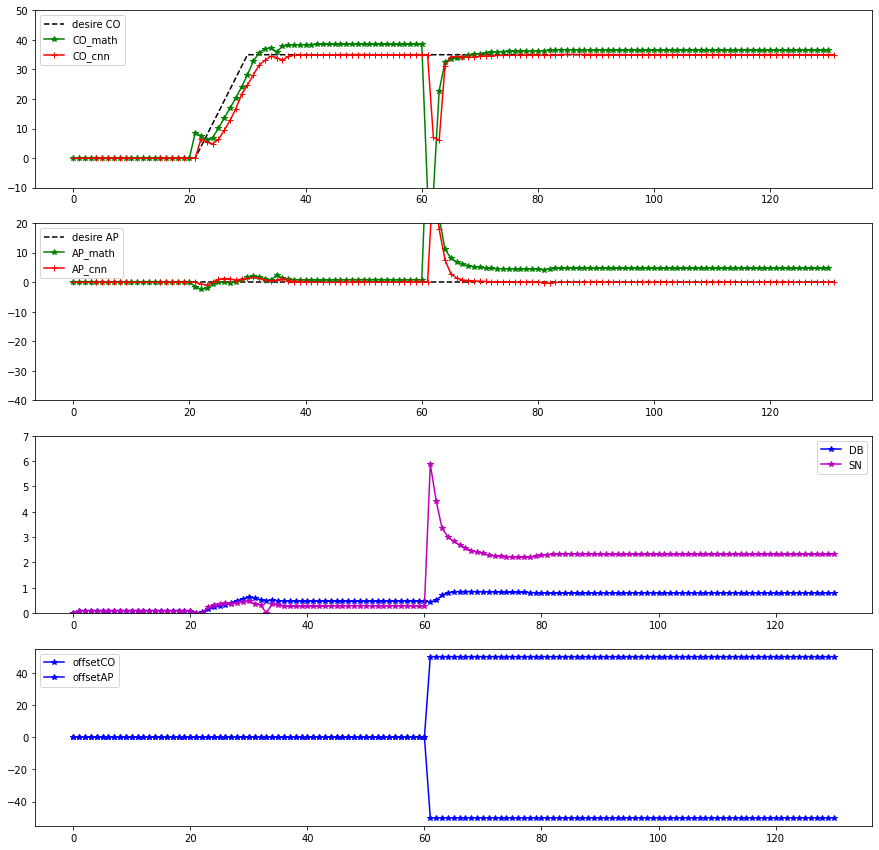

In [ ]:
print(DB_optimize)
plt.figure(figsize=(15,15))

plt.subplot(411)
plt.plot(output_desire_CO, 'k--', label='desire CO')
plt.plot(output_math_CO, 'g-*', label='CO_math')
plt.plot(output_cnn_CO,'r-+', label='CO_cnn')
plt.legend()
plt.ylim((-10, 50))


plt.subplot(412)
plt.plot(output_desire_AP, 'k--', label='desire AP')
plt.plot(output_math_AP, 'g-*', label='AP_math')
plt.plot(output_cnn_AP,'r-+', label='AP_cnn')
plt.legend()
plt.ylim((-40, 20))


plt.subplot(413)
plt.plot(DB_optimize, 'b-*', label='DB')
plt.plot(SN_optimize, 'm-*', label='SN')
plt.legend()
plt.ylim((0, 7))

plt.subplot(414)
plt.plot(OFFSET_CO, 'b-*', label='offsetCO')
plt.plot(OFFSET_AP, 'b-*', label='offsetAP')
plt.legend()


save_to_pickle('/content/drive/MyDrive/drug_infusion/acutedisturbance_unlimited_3.pkl',
               [output_desire_CO, output_math_CO, output_cnn_CO,
                output_desire_AP, output_math_AP, output_cnn_AP,
                DB_optimize, SN_optimize, SENS])
